# EXERCISE 6.1: Land-Use-Land-Cover

---

**Use of Google Earth Engine with Rwandan geodata to train a LULC classifier using various algorithms available in scikitlearn**

Machine Learning (ML) is a powerful technique for analyzing Earth Observation data. The Google Earth Engine (GEE) has built-in capabilities to allow users to build and use ML models for common scenarios with easy-to-use APIs.

A common ML task is to classify the pixels in satellite imagery into two or more categories. The approach is useful for Land Use Land Cover mapping and other popular applications. In the GEE API it is possible to train models. However, sometimes the GEE API has it's limits and you want use GEE results with other APIs. In that case it is common to export images outside GEE and train there, where other python libraries are available.

Identifying areas of human settlement is a large area of focus in Earth Observation and many other disciplines.

The Global Human Settlement Layer (GHSL) dataset is a useful resource for understanding areas of settlement and happily for our purposes, it is available in the GEE catalogue.

The dataset we are particularly interested in is the GHSL “Settlement Grid” layer. The settlement grids in this dataset have been generated via the GHSL built-up areas and population grids, which are themselves derived from Landsat image collections and other sources and these layers are also available on GEE.

The GHSL dataset will be used to get the labels for different regions. We would like to predict the land use based on RGB bands, NIR bands, red edge bands, and average Day/Night Band(DNB) radiance values. The average DNB radiance will be fetched from the *VIIRS Stray Light Corrected Nighttime Day/Night Band Composites Version 1* dataset. The other bands will be fetched from the Sentinel-2 dataset.

Read the following resources if you like further reading on the GEE.

- https://earthengine.google.com/
- https://www.sciencedirect.com/science/article/pii/S0034425717302900



In [ ]:
!pip install geemap rasterio -qqq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 32.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.5/130.5 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 51.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 47.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 81.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 47.9 MB/s eta 0:00:00


# Setup

If you have already run this setup (for e.g as part of Exercise 5_02), please reuse the private key. 
Otherwise, follow the steps at https://docs.google.com/document/d/13SKLn_mqhlaRc1gElr4kmBrkw6KZPeqDDW3AjcTr8YY/

Now mount your google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import required packages

In [ ]:
import ee
import os
import time
import sys
import numpy as np
import pandas as pd
import itertools
import os
import traceback
import urllib
import folium

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from oauth2client.service_account import ServiceAccountCredentials

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize
import seaborn as sns
import geemap
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from scipy.stats import uniform

**Setup GEE Credentials**

Upload the `.private-key.json` you created while setting up GEE to the current runtime (rename your key file if necessary). Click Files > Upload to Session storage on the left pane in this notebook to upload. <br/>
Replace the service account in the code below with your Google Cloud project service account email. It should be of the format <br/>`<id>@ml4eo-<some_number>.iam.gserviceaccount.com`

In [ ]:
service_account = 'ml4eo-420815.iam.gserviceaccount.com'
credentials = ee.ServiceAccountCredentials(service_account, '.private-key.json')
ee.Initialize(credentials)

FileNotFoundError: ignored

Now let's load the following helper function to be used later in the script

In [ ]:
def Mapdisplay(center, dicc, Tiles="OpensTreetMap",zoom_start=10):
    '''
    :param center: Center of the map (Latitude and Longitude).
    :param dicc: Earth Engine Geometries or Tiles dictionary
    :param Tiles: Mapbox Bright,Mapbox Control Room,Stamen Terrain,Stamen Toner,stamenwatercolor,cartodbpositron.
    :zoom_start: Initial zoom level for the map.
    :return: A folium.Map object.
    '''
    mapViz = folium.Map(location=center,tiles=Tiles, zoom_start=zoom_start)
    for k,v in dicc.items():
      if ee.image.Image in [type(x) for x in v.values()]:
        folium.TileLayer(
            tiles = v["tile_fetcher"].url_format,
            attr  = 'Google Earth Engine',
            overlay =True,
            name  = k
          ).add_to(mapViz)
      else:
        folium.GeoJson(
        data = v,
        name = k
          ).add_to(mapViz)
    mapViz.add_child(folium.LayerControl())
    return mapViz

# Datasets

## Global Human Settlement Layers (GHSL)

Source: https://developers.google.com/earth-engine/datasets/catalog/JRC_GHSL_P2016_SMOD_POP_GLOBE_V1

The GHS-SMOD is the rural-urban Settlement classification Model adopted by the Global Human Settlement Layers (GHSL). It is the representation of the degree of urbanization (DEGURBA) concept into the GHSL data scenario. Each grid in the GHS-SMOD has been generated by integrating the GHSL built-up areas and GHSL population grids data for reference epochs: 1975, 1990, 2000, 2015.

In GHSL there is one band with four “degrees of urbanization”:
1. Inhabited areas
2. Rural grid cells
3. Low Density Clusters (towns and cities)
4. High Density Clusters (cities)

We made a choice in framing our analysis that we are interested in the change of the Low and High Density clusters (“built up”) relative to everything else, so we will classify any pixel with values in [2, 3] as “built up” and assign this 1 or not and assign it 0.

A second item worth noting is that the spatial resolution for this grid layer is 1000 meters.

The bands in the GHSL dataset are shown below.

<table class="eecat">
<tbody><tr>
<th scope="col">Name</th>
<th scope="col">Description</th>
</tr>
<tr>
<td><code translate="no" dir="ltr">smod_<wbr>code</code></td>
<td><p>Degree of urbanization</p></td>
</tr>
</tbody></table>

Here is a description of the different values in the smod_code band.
<div class="devsite-table-wrapper"><table class="eecat">
<tbody><tr>
<th scope="col">Value</th>
<th scope="col">Color</th>
<th scope="col">Description</th>
</tr>
<tr>
<td>0</td>
<td><span style="background-color:000000">000000</span></td>
<td>Inhabited areas</td>
</tr>
<tr>
<td>1</td>
<td><span style="background-color:448564">448564</span></td>
<td>RUR (rural grid cells)</td>
</tr>
<tr>
<td>2</td>
<td><span style="background-color:70daa4">70daa4</span></td>
<td>LDC (low density clusters)</td>
</tr>
<tr>
<td>3</td>
<td><span style="background-color:ffffff">ffffff</span></td>
<td>HDC (high density clusters)</td>
</tr>
</tbody></table></div>


---


##  VIIRS Nighttime data 

Source: [Visible Infrared Imaging Radiometer Suite (VIIRS) Stray Light Corrected Nighttime Day/Night Band Composites Version 1 Dataset](https://developers.google.com/earth-engine/datasets/catalog/NOAA_VIIRS_DNB_MONTHLY_V1_VCMSLCFG)

This dataset contains monthly average radiance composite images using nighttime data from the Visible Infrared Imaging Radiometer Suite (VIIRS) Day/Night Band (DNB). The following table describes the different bands present in the VIIRS dataset.

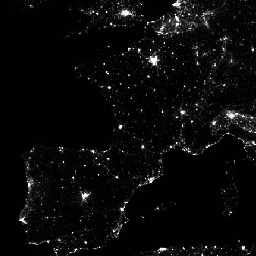
<table class="eecat">
<tbody><tr>
<th scope="col">Name</th>
<th scope="col">Units</th>
<th scope="col">Min</th>
<th scope="col">Max</th>
<th scope="col">Description</th>
</tr>
<tr>
<td><code translate="no" dir="ltr">avg_<wbr>rad</code></td>
<td>nanoWatts/cm2/sr</td>
<td>
          -1.5*
</td>
<td>
          193565*
</td>
<td><p>Average DNB radiance values.</p></td>
</tr>
<tr>
<td><code translate="no" dir="ltr">cf_<wbr>cvg</code></td>
<td></td>
<td>
          0*
</td>
<td>
          84*
</td>
<td><p>Cloud-free coverages; <br>the total number of observations that
went into each pixel. <br>This band can be used to identify areas with low
numbers of observations where the quality is reduced.</p></td>
</tr>
</tbody></table>

## <font color=orange>Discussion:</font>

Please read https://developers.google.com/earth-engine/datasets/catalog/NOAA_VIIRS_DNB_MONTHLY_V1_VCMSLCFG#description which describes the VIIRS dataset.

Why does it make sense to use the average night radiance to determine whether there is settlement in area? 


# Get the Training data

## Get Features from Sentinel-2 and VIIRS


In [ ]:
# Remember this function from Exercise 5_03, what does it do?
def se2mask(image):
    quality_band = image.select('QA60')
    cloudmask = 1 << 10
    cirrusmask = 1 << 11
    mask = quality_band.bitwiseAnd(cloudmask).eq(0) and (quality_band.bitwiseAnd(cirrusmask).eq(0))
    return image.updateMask(mask).divide(10000)

In [ ]:
lat = -1.9441
lon = 30.0619
offset = 0.51
region = [
        [lon + offset, lat - offset],
        [lon + offset, lat + offset],
        [lon - offset, lat + offset],
        [lon - offset, lat - offset]]

roi = ee.Geometry.Polygon([region])

NameError: ignored

In [ ]:
se2bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7','B8','B8A']
trainingbands = se2bands + ['avg_rad']
label = 'smod_code'
scaleFactor=1000

se2 = ee.ImageCollection('COPERNICUS/S2').filterDate("2015-07-01","2015-12-31")

# TODO: Use the filterBounds function to get filter the are specified in ROI
se2 = se2.filterBounds(roi)

# Keep pixels that have less than 20% cloud
se2 = se2.filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE",20))

# Update the mask 
se2 = se2.map(se2mask)

# Get the median image
se2 = se2.median()

se2 = se2.select(se2bands)

viirs = ee.Image(ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG").filterDate(
    "2015-07-01","2015-12-31").filterBounds(roi).median().select('avg_rad').clip(roi))

# TODO: Read https://developers.google.com/earth-engine/apidocs/ee-image-addbands
# Use the function above to fuse the se2 and viirs bands

fused = se2.addBands(viirs)

## Get Labels from GHSL Dataset

In [ ]:
ghsl = ee.ImageCollection('JRC/GHSL/P2016/SMOD_POP_GLOBE_V1').filter(ee.Filter.date(
    '2015-01-01', '2015-12-31')).select(label).median().gte(2).clip(roi)

points = ghsl.sample(**{"region":roi, "scale":scaleFactor,"seed":0,'geometries':True})

In [ ]:
data = fused.select(trainingbands).sampleRegions(collection=points,
                                                        properties=[label],
                                                        scale=scaleFactor)

In [ ]:
data.aggregate_stats(label).getInfo()


{'max': 1,
 'mean': 0.20737724175738115,
 'min': 0,
 'sample_sd': 0.4054439481595326,
 'sample_var': 0.16438479509918977,
 'sum': 2648,
 'sum_sq': 2648,
 'total_count': 12769,
 'total_sd': 0.4054280717445227,
 'total_var': 0.16437192135848186,
 'valid_count': 12769,
 'weight_sum': 12769,
 'weighted_sum': 2648}

## Train-test split
Now that we have gathered our data we would like to split the dataset into training and test sets. We first create a column of random numbers in the range [0, 1] and use that to split the data into training and test sets.

In [ ]:
# we'll create a column of random numbers
data = data.randomColumn(seed=0)

We will use a 80/20 train/test split randomly among the pixels in our 2015 training image

In [ ]:
split_thresh = 0.8
train = data.filter(ee.Filter.lt('random', split_thresh))
test = data.filter(ee.Filter.gte('random', split_thresh))


In [ ]:
train.aggregate_stats(label).getInfo()

{'max': 1,
 'mean': 0.20503243562020837,
 'min': 0,
 'sample_sd': 0.4037451649158013,
 'sample_var': 0.1630101581928876,
 'sum': 2086,
 'sum_sq': 2086.0000000000005,
 'total_count': 10174,
 'total_sd': 0.4037253224208924,
 'total_var': 0.1629941359638535,
 'valid_count': 10174,
 'weight_sum': 10174,
 'weighted_sum': 2086}

In [ ]:
test.aggregate_stats(label).getInfo()

{'max': 1,
 'mean': 0.21083860759493672,
 'min': 0,
 'sample_sd': 0.40798472068423364,
 'sample_var': 0.16645153231179213,
 'sum': 533,
 'sum_sq': 533,
 'total_count': 2528,
 'total_sd': 0.4079040195221972,
 'total_var': 0.166385689142365,
 'valid_count': 2528,
 'weight_sum': 2528,
 'weighted_sum': 533}

## <font color=orange>Discussion:</font>

How many samples are there for training and testing?

How are they balanced between the two classes?

We have 10,252 observations (pixels) in our training set and 2,591 in our test set.

And notice balance of our label is similar for training and testing (~20.5% and ~20.5% classified as built-up, respectively), which we’d expect in a random split.



## Question 6.1.1

Create an 80/10/10 train/val/test split following the same strategy as above.

In [ ]:
# TODO: complete the following codes
train_exercise = 
val_exercise = 
test_exercise = 


SyntaxError: ignored

# Training Using GEE

## Limitations

**Training Set Limits**

Training on GEE itself has some limits.

Training using ee.Classifier or ee.Clusterer is generally effective with datasets up to 100 MB. As a very rough guideline, assuming 32-bit (i.e. float) precision, this can accommodate training datasets that satisfy (where n is the number of examples and b is the number of bands):

nb ≤ (100 * 2^20) / 4

As one example, if you train using 100 bands, the number of examples used for training should be less than 200,000.

**Inference Limits**

Since Earth Engine processes 256x256 image tiles, inference requests on imagery must have fewer than 400 bands (again, assuming 32-bit precision of the imagery).

You can retrain a classifier more than once to keep the dataset for each training run within limits.

**Limits on Model Size**

Additionally, the model itself must be less than 100 MB. Many of our classifiers can be configured to limit their complexity and hence, size. 

## Train a Random Forest classifier
Here we fit the Random Forest estimator to our training data using some initial hyperparameters. Google Earth Engine Python API provides a [Random Forest Classifier](https://developers.google.com/earth-engine/apidocs/ee-classifier-smilerandomforest). The details of the RF classifier are given in the table below.

<table class="blue"><thead><tr><th>Usage</th><th>Returns</th></tr></thead><tbody><tr><td><code translate="no" dir="ltr">ee.<wbr>Classifier.<wbr>smileRandomForest(<wbr>numberOfTrees,<wbr> <i>variablesPerSplit</i>,<wbr> <i>minLeafPopulation</i>,<wbr> <i>bagFraction</i>,<wbr> <i>maxNodes</i>,<wbr> <i>seed</i>)</code></td><td>Classifier</td></tr></tbody></table>

<div class="devsite-table-wrapper"><table class="details"><thead><tr><th>Argument</th><th>Type</th><th>Details</th></tr></thead><tbody><tr><td><code translate="no" dir="ltr">numberOfTrees</code></td><td>Integer</td><td>The number of decision trees to create.</td></tr><tr class="docs-arg-optional"><td><code translate="no" dir="ltr">variablesPerSplit</code></td><td>Integer, default: null</td><td>The number of variables per split. If unspecified, uses the square root of the number of variables.</td></tr><tr class="docs-arg-optional"><td><code translate="no" dir="ltr">minLeafPopulation</code></td><td>Integer, default: 1</td><td>Only create nodes whose training set contains at least this many points.</td></tr><tr class="docs-arg-optional"><td><code translate="no" dir="ltr">bagFraction</code></td><td>Float, default: 0.5</td><td>The fraction of input to bag per tree.</td></tr><tr class="docs-arg-optional"><td><code translate="no" dir="ltr">maxNodes</code></td><td>Integer, default: null</td><td>The maximum number of leaf nodes in each tree. If unspecified, defaults to no limit.</td></tr><tr class="docs-arg-optional"><td><code translate="no" dir="ltr">seed</code></td><td>Integer, default: 0</td><td>The randomization seed.</td></tr></tbody></table></div>

In [ ]:
init_params = {"numberOfTrees":100, # the number of individual decision tree models
              "variablesPerSplit":None,  # the number of features to use per split
              "minLeafPopulation":1, # smallest sample size possible per leaf
              "bagFraction":0.5, # fraction of data to include for each individual tree model
              "maxNodes":None, # max number of leafs/nodes per tree
              "seed":42}  # random seed for "random" choices like sampling. Setting this allows others to reproduce your exact results even with stocastic parameters

clf = ee.Classifier.smileRandomForest(**init_params).train(train, label, trainingbands)

## Evaluation
We need metrics to determine how well the classifier performs. We just have a simple binary schema so we can visualize a confusion matrix, which shows the actual labels (y axis) and the predicted labels (x axis).

In [ ]:
trainResults = clf.confusionMatrix().getInfo()
trainCM = pd.DataFrame(np.asarray(trainResults), index=['not','built-up'], columns=['not','built-up'])

## Question 6.1.2
Use your favorite Python plotting package to visualize the confusion matrix as a heatmap.

**Expected Output** 

It is okay if the color scheme or the numbers are different. The following image is just to show you the kind of diagram you are expected to draw.

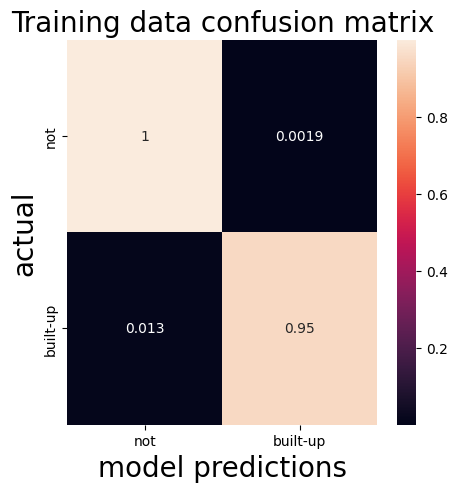

In [ ]:
fig, ax = plt.subplots(1, figsize=(5,5))
sns.heatmap(trainCM/trainCM.sum(axis=1), annot=True)
ax.set_xlabel('model predictions', fontsize=20)
ax.set_ylabel('actual', fontsize=20)
plt.title("Training data\nconfusion matrix", fontsize=20)

NameError: ignored

## Question 6.1.3
What is the overall accuracy related to the confusion matrix above?

In [ ]:
oa = (trainCM.loc['built-up','built-up'] + trainCM.loc['not','not']) / trainCM.sum().sum()
print(oa)

0.9888316985529766


## Evaluation

We need to know how the classifier will perform on unseen data, i.e. data he was not trained on.


In [ ]:
testResults = test.classify(clf).errorMatrix(label, 'classification').getInfo()

## Question 6.1.4
Use your favorite Python plotting package to visualize the confusion matrix as a heatmap.

Text(0.5, 1.0, 'Test data confusion matrix')

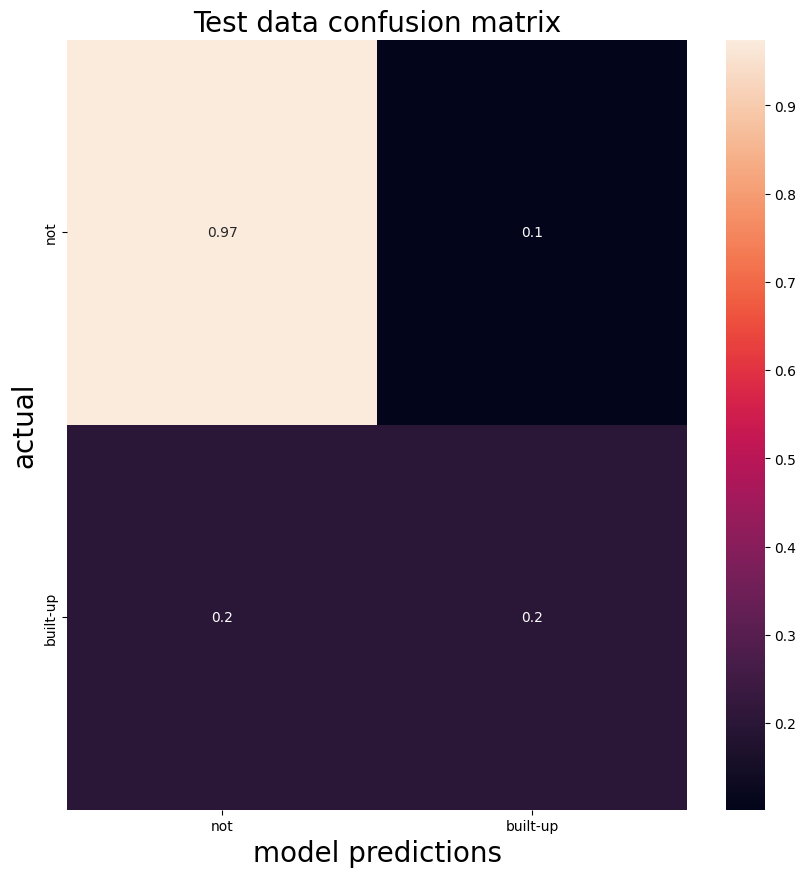

In [ ]:
testCM = pd.DataFrame(np.asarray(testResults), index=['not','built-up'], columns=['not','built-up'])

fig, ax = plt.subplots(1, figsize=(10,10))
sns.heatmap(testCM/testCM.sum(axis=1), annot=True)
ax.set_xlabel('model predictions', fontsize=20)
ax.set_ylabel('actual', fontsize=20)
plt.title("Test data\nconfusion matrix", fontsize=20)

## Question 6.1.5
Compute the overall accuracy on the test set from the confusion matrix above.

In [ ]:
oa = (testCM.loc['built-up','built-up'] + testCM.loc['not','not']) / testCM.sum().sum()
print(oa)

## Standardize the Data
Let's see how the results will change if we standardize the data.

In [ ]:
# Compute the mean and standard deviation
vmu = viirs.reduceRegion(reducer=ee.Reducer.mean(),scale=scaleFactor)
vstd = viirs.reduceRegion(reducer=ee.Reducer.stdDev(),scale=scaleFactor)

vmu = ee.Number(vmu.get('avg_rad'))
vstd = ee.Number(vstd.get('avg_rad'))

# Whiten the band
viirsclean = viirs.subtract(vmu).divide(vstd)

# 


## Question 6.1.6
Do the following.
1. Fuse the `viirsclean` to `se2` and assign it to a variable named `fusedclean`
2. Sample data points from `fusedclean` and assign the sampled points to `dataclean`
3. Split `dataclean` into training and test sets (80/20 split)
4. Initialize new RF classifier with parameters and train it on the training set
```
new_params = {"numberOfTrees":500, 
              "variablesPerSplit":None,  
              "minLeafPopulation":1, 
              "bagFraction":0.5, 
              "maxNodes":None, 
               "seed":0}
```
5. Evaluate the trained classifier on the test set and display the confusion matrix

Our classifier has an accuracy of 0.81772 on the test data.


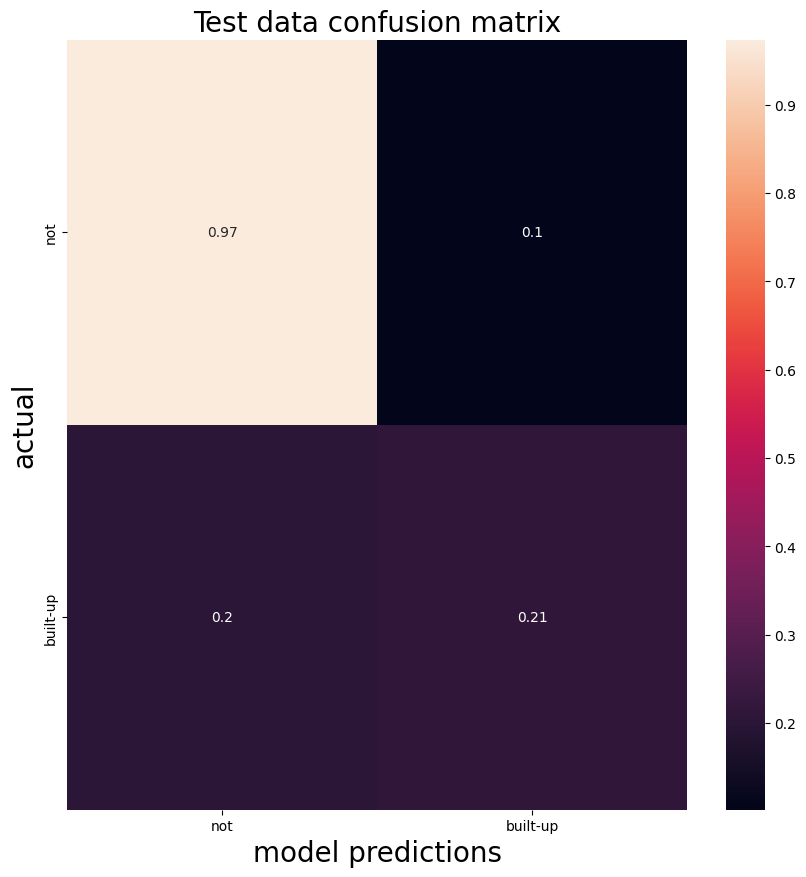

In [ ]:
fusedclean = se2.addBands(viirsclean)

dataclean = fusedclean.select(trainingbands).sampleRegions(collection=points,
                                                        properties=[label],
                                                        scale=scaleFactor)

# we'll create a column of random numbers
dataclean = dataclean.randomColumn(seed=0)
split_thresh = 0.8

trainclean = dataclean.filter(ee.Filter.lt('random',split_thresh))
testclean = dataclean.filter(ee.Filter.gte('random',split_thresh))

new_params = {"numberOfTrees":500, 
              "variablesPerSplit":None,  
              "minLeafPopulation":1, 
              "bagFraction":0.5, 
              "maxNodes":None, 
               "seed":0}

clf2 = ee.Classifier.smileRandomForest(**new_params).train(trainclean, label, trainingbands)

testResults = testclean.classify(clf2).errorMatrix(label, 'classification').getInfo()
testCM = pd.DataFrame(np.asarray(testResults), index=['not','built-up'], columns=['not','built-up'])

fig, ax = plt.subplots(1, figsize=(5,5))
sns.heatmap(testCM/testCM.sum(axis=1), annot=True)
ax.set_xlabel('model predictions', fontsize=20)
ax.set_ylabel('actual', fontsize=20)
plt.title("Test data\nconfusion matrix", fontsize=20);
acc = (testCM.loc['built-up','built-up'] + testCM.loc['not','not']) / testCM.sum().sum()
print(f"Our classifier has an accuracy of {acc:.5f} on the test data.")

## Visualize the Results
Applying that last trained classifier (but on non cleaned training data) on our entire image, we can visualize the predicted land cover.


In [ ]:
result = fused.select(trainingbands).classify(clf2)

ghslVis= {"palette":['000000', 'ffffff']}
se2Vis = {"min":0.0, "max":0.3,"bands": ['B4','B3','B2']}

# initialize our map
map1 = geemap.Map()
map1.centerObject(roi, 9)
map1.addLayer(se2, se2Vis, "S2")
map1.addLayer(viirs, {}, "VIIRS-DNB")
map1.addLayer(ghsl, ghslVis, "GHSL")
map1.addLayer(result.randomVisualizer(), {}, 'classified')
map1.addLayerControl()
map1

Map(center=[-1.9441255824721086, 30.061900000000037], controls=(WidgetControl(options=['position', 'transparen…

# Training and Prediction outside GEE
In Exercise 5_03 we saw how we can transfer data from GEE to a local setup. Training in a local setup is preferable in most cases.

Deep learning and neural networks are machine-learning techniques that can work well for complex data like satellite imagery. Neither deep learning nor neural networks are supported in GEE's Machine Learning APIs. Instead, to take advantage of them, you will need to use a framework like TensorFlow or PyTorch and train your model outside of Earth Engine.

You may also want to train outside of GEEif you are already familiar with a framework like [scikit-learn](https://scikit-learn.org) for classical machine learning or [XGBoost](https://xgboost.readthedocs.io) for gradient boosted decision trees.

Finally, you may want to train a model outside GEE if your data set is very large and exceeds the limits documented above.

First, let's see the datatype of the `dataclean` datatype.

In [ ]:
print(type(dataclean))


NameError: ignored

You can see that the type of `dataclean` is FeatureCollection. Let's now see how we can export the feature collection as CSV so we can use tools such as pandas to load and manipulate the data.

In [ ]:
def export_one_table(feature_collection, name):
  """Uses a GEE API to batch transfer data to a GCP project Google Drive"""
  task = ee.batch.Export.table.toDrive(**{
    'collection': feature_collection,
    'description': name,
    'fileFormat': 'CSV'
    })
  task.start()
  while task.active():
    print('Running...')
    # Wait for sometime before showing an update
    time.sleep(100)
  print('Done..', task.status())



Running...
Done.. {'state': 'COMPLETED', 'description': 'GEEToDrive', 'creation_timestamp_ms': 1683525078879, 'update_timestamp_ms': 1683525096317, 'start_timestamp_ms': 1683525084736, 'task_type': 'EXPORT_FEATURES', 'destination_uris': ['https://drive.google.com/'], 'attempt': 1, 'batch_eecu_usage_seconds': 7.928635597229004, 'id': 'CRRIKJQTERZMSM4MHEZY2KQP', 'name': 'projects/earthengine-legacy/operations/CRRIKJQTERZMSM4MHEZY2KQP'}


In [ ]:
name = 'GEEToDrive'
export_one_table(dataclean, name)

Move the CSV from service account Google Drive to a user user Google Drive.

In [ ]:
# Transfer the data from GCP service account drive to current working directory in Colaboratory
gauth = GoogleAuth()
scopes = ['https://www.googleapis.com/auth/drive']
gauth.credentials = ServiceAccountCredentials.from_json_keyfile_name(".private-key.json", scopes=scopes)

drive = GoogleDrive(gauth)

# get list of files
file_list = drive.ListFile({'q': "trashed=false"}).GetList()
print(f"{len(file_list)} files found")
for file_tiff in file_list:

        filename = file_tiff['title']
        if file_tiff['mimeType'] == 'text/csv':
          # download file into working directory (in this case a tiff-file)
          file_tiff.GetContentFile(filename, mimetype="image/tiff")

          # delete file afterwards to keep the Drive empty
          file_tiff.Delete()

4 files found


## Read the Downloaded CSV

Now that we have the CSV file we can use widely used Python tools such as Pandas, Numpy, and Sci-kit Learn to preprocess the data and train our models.

In [ ]:
df = pd.read_csv('GEEToDrive.csv')

In [ ]:
df.head()

,system:index,B2,B3,B4,B5,B6,B7,B8,B8A,avg_rad,random,smod_code,.geo
0,0_0,0.0871,0.0905,0.0830,0.1218,0.2286,0.2685,0.2559,0.2919,-0.086878,0.078297,1,"{""type"":""MultiPoint"",""coordinates"":[]}"
1,1_0,0.0872,0.0891,0.0789,0.1160,0.2245,0.2653,0.2533,0.2885,-0.070507,0.558061,0,"{""type"":""MultiPoint"",""coordinates"":[]}"
2,2_0,0.2296,0.2265,0.2307,0.2563,0.3324,0.3655,0.3482,0.3845,-0.089565,0.411844,0,"{""type"":""MultiPoint"",""coordinates"":[]}"
3,3_0,0.1640,0.1624,0.1600,0.1877,0.2672,0.3007,0.2844,0.3228,-0.093732,0.507770,1,"{""type"":""MultiPoint"",""coordinates"":[]}"
4,4_0,0.0992,0.0980,0.0885,0.1203,0.2117,0.2474,0.2373,0.2707,-0.050745,0.496830,0,"{""type"":""MultiPoint"",""coordinates"":[]}"


## Sklearn Train Test Split
Similar to what we did from GEE, let's split the dataset into train and test sets. First, let's split the label from the features.

In [ ]:
X = df[trainingbands]
X.head()

,B2,B3,B4,B5,B6,B7,B8,B8A,avg_rad
0,0.0871,0.0905,0.0830,0.1218,0.2286,0.2685,0.2559,0.2919,-0.086878
1,0.0872,0.0891,0.0789,0.1160,0.2245,0.2653,0.2533,0.2885,-0.070507
2,0.2296,0.2265,0.2307,0.2563,0.3324,0.3655,0.3482,0.3845,-0.089565
3,0.1640,0.1624,0.1600,0.1877,0.2672,0.3007,0.2844,0.3228,-0.093732
4,0.0992,0.0980,0.0885,0.1203,0.2117,0.2474,0.2373,0.2707,-0.050745


In [ ]:
y = df[label]
y.head()

0    1
1    0
2    0
3    1
4    0
Name: smod_code, dtype: int64

In [ ]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Let's now create a Random Forest classifier with the parameters we used to train the random forest classifier in GEE.

In [ ]:
new_params_sk = {"n_estimators":500, 
              "max_features": "sqrt",
              "min_samples_leaf":1,
              "bootstrap": True,
              "max_samples": 0.5,
              "max_leaf_nodes":None,
              "random_state":42}

In [ ]:
clf = RandomForestClassifier(**new_params_sk)

In [ ]:
clf.fit(X_train, y_train)

RandomForestClassifier(max_samples=0.5, n_estimators=500, random_state=42)

## Question 6.1.7 
Use `sklearn.metrics.confusion_matrix`, `sklearn.metrics.accuracy_score`, `sklearn.metrics.f1_score` and `clf.predict` to compute the confusion matrix, accuracy, and f1 score on the test set.

# Hyperparameter Search from scikit-learn

One of the advantages of training a model outside GEE is the ease of hyperparameter tuning. For this example we will use the [`sklearn.model_selection.RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) to find the best hyperparameters for this task.

In [ ]:
distributions = {
    "n_estimators": [10, 50, 100, 200],
    "bootstrap": [True, False],
    "max_samples": [0.2, 0.4, 0.6],
    "max_features": ["sqrt", "log", None],
    "min_samples_leaf": [1, 2, 3, 4],
}

In [ ]:
rf = RandomForestClassifier()
clf = RandomizedSearchCV(estimator=rf, 
                         param_distributions=distributions,
                         n_iter=10,
                         random_state=42, 
                         cv=5, # 5-fold cross validation
                         n_jobs=os.cpu_count(),
                         verbose=1)
print(clf)

NameError: ignored

In [ ]:
# this might take a while - time for tea
search = clf.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [ ]:
search.best_params_

{'n_estimators': 500,
 'min_samples_leaf': 3,
 'max_samples': 0.4,
 'max_features': None,
 'bootstrap': True}

## Question 6.1.8

Which hyperparameters were used for the best-performing Random Forest Classifier?

Train a Random Forest classifier with the best parameters found from the hyperparameter search and evaluate on the test set by computing the confusion matrix, accuracy, and f1 score on the test set.

In [ ]:
clf = RandomForestClassifier(**search.best_params_)
clf.fit(X_train, y_train)

## Question 6.1.9
Use the best parameters you got from the hyperparameter search to train a Random Forest classifier within GEE. 

Evaluate on the test set by computing:

* confusion matrix?
* overall accuracy, user- and producer accuray?
* f1 scores?